In [1]:
import tensorflow as tf
from tensorflow import keras
import sklearn
import numpy as np
np.random.seed(42)
import matplotlib as mpl
import matplotlib.pyplot as plt

import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import os
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.applications import ResNet50V2

from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetB0

print(tf.__version__)

2.17.1


This is our resnet model

In [2]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [00:13<00:00, 177MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [3]:
img_size = (220, 220)
batch_size = 32

# Create train, test, and validation datasets
train_dataset = image_dataset_from_directory(
    os.path.join(path, 'chest_xray', 'train'),
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    color_mode='rgb'
)

test_dataset = image_dataset_from_directory(
    os.path.join(path, 'chest_xray', 'test'),
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    color_mode='rgb'
)

val_dataset = image_dataset_from_directory(
    os.path.join(path, 'chest_xray', 'val'),
    labels='inferred',
    label_mode='binary',
    image_size=img_size,
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    color_mode='rgb'
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [4]:
train_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),  # Random horizontal flip
    tf.keras.layers.RandomBrightness(factor=0.2),  # Random brightness adjustment
    tf.keras.layers.RandomContrast(factor=0.2),    # Random contrast adjustment
    #tf.keras.layers.Rescaling(offset=-1, scale=2), # Normalize (equivalent to mean=0.5, std=0.5)
])

In [5]:
#cast  dataset to float
train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), y))
#augment dataset, store in new dataset
train_aug_dataset = train_dataset.map(lambda x, y: (train_augmentation(x), y))
#remove pnuemonioa cases from augmented
normal_ds = train_aug_dataset.unbatch().filter(lambda x, y:  tf.equal(y[0], 0.) ).batch(32)
#put back into our training
train_dataset = train_dataset.concatenate(train_aug_dataset)

In [6]:
model_checkpoint_callback_resnet = tf.keras.callbacks.ModelCheckpoint(
    filepath="./resweights.weights.h5",
    save_weights_only=True,
    monitor='val_loss',  # Monitor validation loss
    mode='min',  # Save the model when validation loss is minimized
    save_best_only=True  # Only save the best model
)

In [7]:
resnet50 = ResNet50V2(weights="imagenet", input_shape=(220, 220, 3), include_top=False)
model = Sequential()
model.add(resnet50)

for layer in resnet50.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(2048, activation="relu"))
model.add(Dropout(0.5))
# model.add(Dense(2048, activation="relu"))
# model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │     205,522,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 229,089,793 (873.91 MB)

 Trainable params: 205,524,993 (784.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [9]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [10]:
model.fit(
    train_dataset,
    batch_size=32,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[model_checkpoint_callback_resnet]
)

Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 148s 399ms/step - accuracy: 0.8428 - loss: 707.9603 - val_accuracy: 0.6250 - val_loss: 5.9326
Epoch 2/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 112s 342ms/step - accuracy: 0.9229 - loss: 3.4563 - val_accuracy: 0.8750 - val_loss: 0.5088
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 95s 290ms/step - accuracy: 0.9302 - loss: 0.5645 - val_accuracy: 0.5625 - val_loss: 2.2781
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 90s 277ms/step - accuracy: 0.9283 - loss: 0.5165 - val_accuracy: 0.7500 - val_loss: 4.4965
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 94s 287ms/step - accuracy: 0.8949 - loss: 0.7477 - val_accuracy: 0.6250 - val_loss: 0.9561


In [11]:
model.load_weights('./resweights.weights.h5')

In [12]:
loss, accuracy = model.evaluate(test_dataset)
print("Loss:", loss)
print("Accuracy:", accuracy)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 0.8680 - loss: 1.0472
Loss: 0.8039225339889526
Accuracy: 0.8878205418586731


This next section creates a confusion matrix

In [13]:
y_pred_prob = model.predict(test_dataset)  # Predicted probabilities

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 293ms/step


In [14]:
threshold = 0.4  # Custom threshold
y_pred_classes = (y_pred_prob > threshold).astype(int).flatten()  # Convert probabilities to binary classes

In [15]:
y_true = []
for images, labels in test_dataset:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))  # Removed target_names for now


Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.74      0.82       234
         1.0       0.86      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



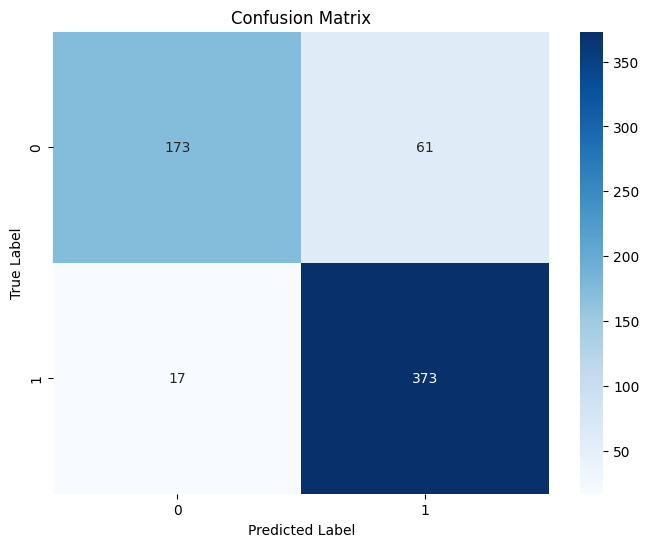

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")  # Removed xticklabels and yticklabels for now
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()